# AnyoneAI - Sprint Project 02
> Home Credit Default Risk

You've been learning a lot about Machine Learning Algorithms, now we you're gonna be asked to put it all togheter.

You will create a complete pipeline to preprocess the data, train your model and then predict values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.


## 1. Introduction

This is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay their debt or not. Our model will have to predict a 1 indicating the client will have payment difficulties: he/she will have late payment of more than X days on at least one of the first Y installments of the loan in our sample, 0 in all other cases.

The dataset is composed of multiple files with different information about loans taken. In this project, we will work exclusively with the primary files: `application_train_aai.csv` and `application_test_aai.csv`.

We will use [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

In [1]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.utils.validation import check_is_fitted

import lightgbm as lgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src import config, data_utils, preprocessing

### Getting the data

To access the data for this project, you only need to execute the code below. This will download three files inside the `dataset` folder:

- `application_train_aai.csv`: Training dataset you must use to train and find the best hyperparameters on your model.

- `application_test_aai.csv`: Test dataset without labels. Because of the absence of labels, you can't use this dataset for your experiments. You will use the file only at the end after you choose what you think is the best model for the tasks. You will have to use that model to fill values in the `TARGET` column using the model predictions. Then submit this dataset alongside this Jupyter notebook, AnyoneAI will internally evaluate your model's accuracy in the hidden data and communicate later ;).

- `HomeCredit_columns_description.csv`: This file contains descriptions for the columns in train and test datasets.


1.1. Load the training and test datasets. Also, the auxiliary file `HomeCredit_columns_description.csv` has additional information about the features in the dataset.

**Don't change anything in this cell, just make it run correctly**

In [2]:
app_train, app_test, columns_description = data_utils.get_datasets()


if app_train.shape == (246008, 122):
    print("Success: app_train shape is correct!")
else:
    raise ValueError("Train dataset shape is incorrect, please review your code")

if isinstance(app_train, pd.DataFrame):
    print("Success: app_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if app_test.shape == (61503, 122):
    print("Success: app_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(app_test, pd.DataFrame):
    print("Success: app_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Success: app_train shape is correct!
Success: app_train type is correct!
Success: app_test shape is correct!
Success: app_test type is correct!


In [3]:
descriptions = columns_description[['Row', 'Description']]

In [4]:
descriptions[descriptions['Row'] == 'TARGET']['Description'].values

array(['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'],
      dtype=object)

### Exploratory Data Analysis

A lot of the analysis of the data can be found on publicly available Kaggle kernels or blog posts, but you need to make sure you understand the dataset's properties before starting working on it, so we'll do exploratory data analysis for the main files.

#### Dataset Basics

1.2. Print how many samples do we have in our train and test datasets.

In [5]:
### TODO Complete in this cell: shape of the dataset

print(app_train.shape)
print(app_test.shape)

(246008, 122)
(61503, 122)


1.3. List all columns in the train dataset.

In [6]:
### TODO Complete in this cell: Show all columns in the training dataset

list(app_train.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

1.4. Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows, make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

For reference only, it should look like this:

|0|1|2|3|4
|---|---|---|---|---
Unnamed: 0|187399|84777|268140|270686|33785
SK_ID_CURR|317244|198357|410700|413785|139141
TARGET|0|0|0|0|0
NAME_CONTRACT_TYPE|Cash loans|Cash loans|Cash loans|Cash loans|Cash loans
...|...|...|...|...|...
AMT_REQ_CREDIT_BUREAU_DAY|0.0|0.0|0.0|0.0|0.0

In [7]:
### TODO Complete in this cell: show first 5 records in a transposed table

with pd.option_context('display.max_rows', None,):
  print(app_train.head(n=2).transpose())

                                              0                      1
SK_ID_CURR                               428247                 140966
TARGET                                        0                      0
NAME_CONTRACT_TYPE                   Cash loans             Cash loans
CODE_GENDER                                   F                      M
FLAG_OWN_CAR                                  N                      Y
FLAG_OWN_REALTY                               N                      Y
CNT_CHILDREN                                  0                      1
AMT_INCOME_TOTAL                       157500.0                90000.0
AMT_CREDIT                             634500.0              1223010.0
AMT_ANNUITY                             30523.5                51948.0
AMT_GOODS_PRICE                        634500.0              1125000.0
NAME_TYPE_SUITE                   Unaccompanied          Unaccompanied
NAME_INCOME_TYPE                      Pensioner                Working
NAME_E

1.5. Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

In [8]:
### TODO Complete in this cell: show distribution of target variable

# sns.histplot(data=app_train, x='TARGET', discrete=True)

target_dist = app_train.groupby('TARGET').agg({'TARGET':'count'}).rename(columns={'TARGET':'count'})
target_dist['percentage'] = 100*target_dist['count']/target_dist['count'].sum()
target_dist

,count,percentage
TARGET,,
0,226257,91.971399
1,19751,8.028601


1.6. Show the number of columns of each data type.

Just for giving you an idea, the output should look like this (not exactly the same numbers):

```python
float64    45
int64      32
object     10
```

In [9]:
### TODO Complete in this cell: show number of columns per data type

app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

1.7. For categorical variables (`object` data type), show the number of distinct values in each column (number of labels).

Just for giving you an idea, the output should look like this (not exactly the same numbers):

```python
NAME_CONTRACT_TYPE             5
CODE_GENDER                    2
FLAG_OWN_CAR                   1
FLAG_OWN_REALTY                1
...
```

In [10]:
### TODO Complete in this cell: show number of unique values per categorical column

cat_cols = list(app_train.dtypes[app_train.dtypes == 'object'].index)
app_train[cat_cols].agg(lambda col: len(col.value_counts().index))

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [11]:
nans_per_col = app_train[cat_cols].agg(lambda col: col.isna().sum())
nans_per_col[lambda x: x > 0]

NAME_TYPE_SUITE          1033
OCCUPATION_TYPE         77119
FONDKAPREMONT_MODE     168561
HOUSETYPE_MODE         123775
WALLSMATERIAL_MODE     125437
EMERGENCYSTATE_MODE    116932
dtype: int64

In [12]:
nans_per_col[lambda x: x == 0]

NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
WEEKDAY_APPR_PROCESS_START    0
ORGANIZATION_TYPE             0
dtype: int64

In [13]:
app_train[['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']].isna().sum()

NAME_CONTRACT_TYPE          0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
EMERGENCYSTATE_MODE    116932
dtype: int64

In [14]:
app_train[cat_cols]['NAME_INCOME_TYPE'].value_counts()

Working                 127136
Commercial associate     57190
Pensioner                44241
State servant            17399
Unemployed                  19
Student                     11
Businessman                  8
Maternity leave              4
Name: NAME_INCOME_TYPE, dtype: int64

1.8. Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending (show only the 20 columns with higher missing pct)

Just for giving you an idea, the output should look like this (not exactly the same numbers and columns names):

```python
                   Total   Percent
COMMONAREA_AVG    121000      85.2
COMMONAREA_MODE   121000      76.6
COMMONAREA_MEDI   121000      62.9
...
```

In [15]:
### TODO Complete in this cell: checking missing data

miss_data = pd.DataFrame({'Total' : app_train.agg(lambda col: col.isna().sum())})
miss_data['Percentage'] = 100*miss_data['Total']/len(app_train)
miss_data.sort_values(by='Total', ascending=False).head(20)

,Total,Percentage
COMMONAREA_MEDI,172189,69.993252
COMMONAREA_AVG,172189,69.993252
COMMONAREA_MODE,172189,69.993252
NONLIVINGAPARTMENTS_MODE,171096,69.548958
NONLIVINGAPARTMENTS_AVG,171096,69.548958
NONLIVINGAPARTMENTS_MEDI,171096,69.548958
FONDKAPREMONT_MODE,168561,68.518503
LIVINGAPARTMENTS_MODE,168494,68.491269
LIVINGAPARTMENTS_AVG,168494,68.491269
LIVINGAPARTMENTS_MEDI,168494,68.491269


In [16]:
miss_data.loc['CODE_GENDER']

Total         0.0
Percentage    0.0
Name: CODE_GENDER, dtype: float64

#### Analyzing distribution of variables

1.9. Show the distribution of credit amounts.

*Hint:* Take a look at `AMT_CREDIT` column.

<AxesSubplot: xlabel='AMT_CREDIT', ylabel='Count'>

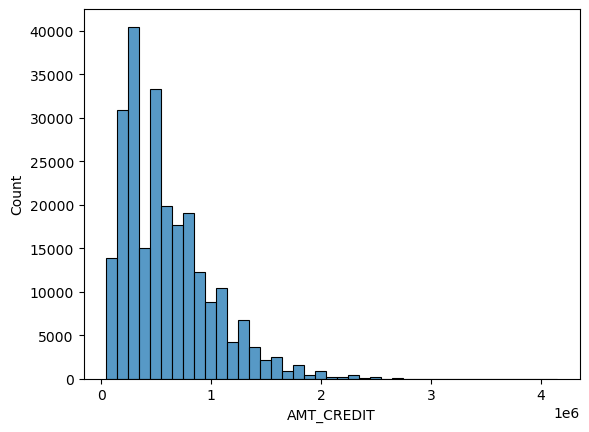

In [17]:
### TODO Complete in this cell: distribution of credit amounts

sns.histplot(data=app_train, x='AMT_CREDIT', binwidth=100000)

1.10. Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

*Hint:* Take a look at `NAME_EDUCATION_TYPE` column.

In [18]:
### TODO Complete in this cell: level of education plot

education_dist = app_train.groupby('NAME_EDUCATION_TYPE').agg({'NAME_EDUCATION_TYPE':'count'}).rename(columns={'NAME_EDUCATION_TYPE':'count'})
education_dist['percentage'] = 100*education_dist['count']/education_dist['count'].sum()
education_dist.reset_index(inplace=True)
education_dist

,NAME_EDUCATION_TYPE,count,percentage
0,Academic degree,129,0.052437
1,Higher education,59990,24.385386
2,Incomplete higher,8248,3.352736
3,Lower secondary,2984,1.212969
4,Secondary / secondary special,174657,70.996472


<AxesSubplot: xlabel='percentage', ylabel='NAME_EDUCATION_TYPE'>

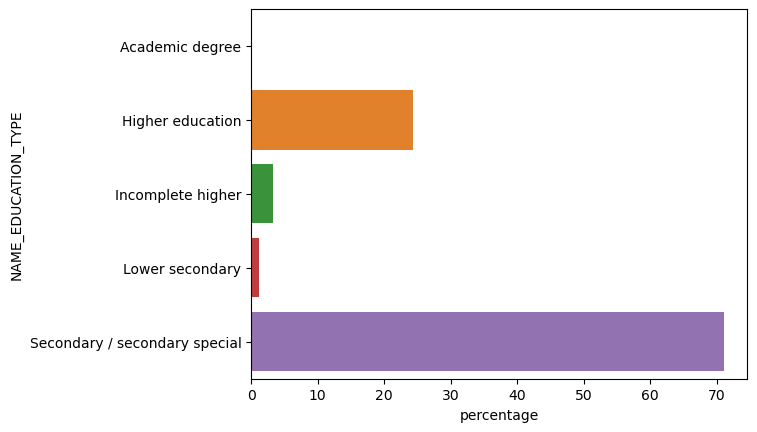

In [19]:
sns.barplot(data=education_dist, y='NAME_EDUCATION_TYPE', x='percentage')

1.11. Plot the distribution of ocupation of the loan applicants.

*Hint:* Take a look at `OCCUPATION_TYPE` column.

In [20]:
### TODO Complete in this cell: ocupation of applicants

occupation_dist = app_train.groupby('OCCUPATION_TYPE').agg({'OCCUPATION_TYPE':'count'}).rename(columns={'OCCUPATION_TYPE':'count'})
occupation_dist['percentage'] = 100*occupation_dist['count']/occupation_dist['count'].sum()
occupation_dist.reset_index(inplace=True)
occupation_dist

,OCCUPATION_TYPE,count,percentage
0,Accountants,7915,4.686510
1,Cleaning staff,3731,2.209143
2,Cooking staff,4771,2.824932
3,Core staff,22041,13.050584
4,Drivers,14874,8.806968
5,HR staff,431,0.255197
6,High skill tech staff,8981,5.317694
7,IT staff,443,0.262302
8,Laborers,44108,26.116562
9,Low-skill Laborers,1687,0.998881


<AxesSubplot: xlabel='percentage', ylabel='OCCUPATION_TYPE'>

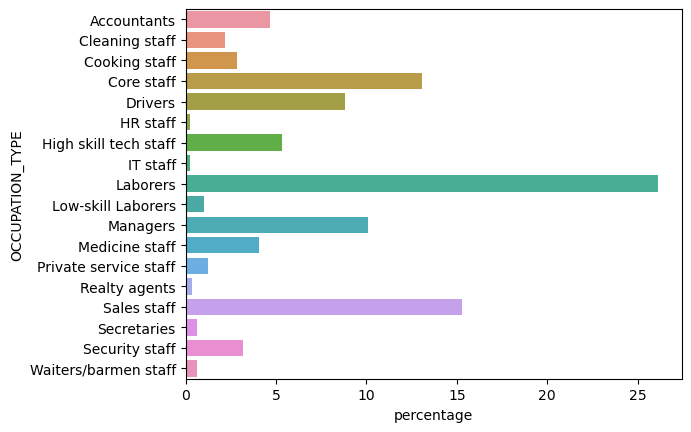

In [21]:
sns.barplot(data=occupation_dist, y='OCCUPATION_TYPE', x='percentage')

1.12. Plot the family status of the applicants.

*Hint:* Take a look at `NAME_FAMILY_STATUS` column.

In [22]:
### TODO Complete in this cell: family status

family_dist = app_train.groupby('NAME_FAMILY_STATUS').agg({'NAME_FAMILY_STATUS':'count'}).rename(columns={'NAME_FAMILY_STATUS':'count'})
family_dist['percentage'] = 100*family_dist['count']/family_dist['count'].sum()
family_dist.reset_index(inplace=True)
family_dist

,NAME_FAMILY_STATUS,count,percentage
0,Civil marriage,23841,9.691148
1,Married,157165,63.886134
2,Separated,15803,6.423775
3,Single / not married,36315,14.761715
4,Unknown,1,0.000406
5,Widow,12883,5.236822


<AxesSubplot: xlabel='percentage', ylabel='NAME_FAMILY_STATUS'>

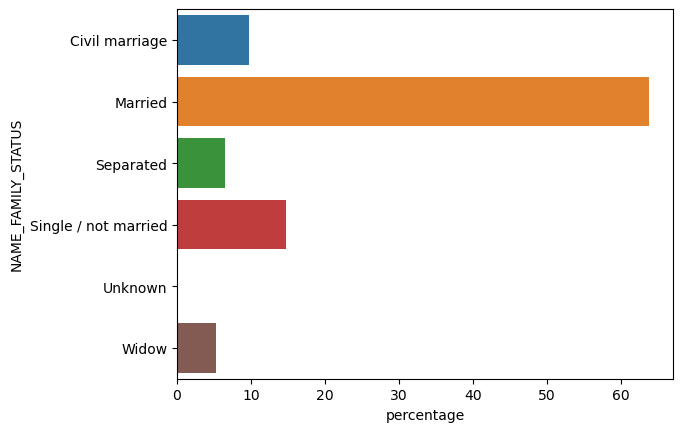

In [23]:
sns.barplot(data=family_dist, y='NAME_FAMILY_STATUS', x='percentage')

1.13. Plot the income type of applicants grouped by the target variable.

*Hint:* Take a look at `NAME_INCOME_TYPE` and `TARGET` columns. You can use `hue` parameter on Seaborn to group samples using another categorical feature.

In [24]:
### TODO Complete in this cell: Income type of applicants by target variable

income_dist = app_train.groupby(by=['NAME_INCOME_TYPE', 'TARGET']).agg({'NAME_INCOME_TYPE':'count'}).rename(columns={'NAME_INCOME_TYPE':'count'})
income_dist['percentage'] = 100*income_dist['count']/income_dist['count'].sum()
income_dist.reset_index(inplace=True)
income_dist

,NAME_INCOME_TYPE,TARGET,count,percentage
0,Businessman,0,8,0.003252
1,Commercial associate,0,52917,21.510276
2,Commercial associate,1,4273,1.736935
3,Maternity leave,0,3,0.001219
4,Maternity leave,1,1,0.000406
5,Pensioner,0,41902,17.032779
6,Pensioner,1,2339,0.950782
7,State servant,0,16411,6.670921
8,State servant,1,988,0.401613
9,Student,0,11,0.004471


<AxesSubplot: xlabel='percentage', ylabel='NAME_INCOME_TYPE'>

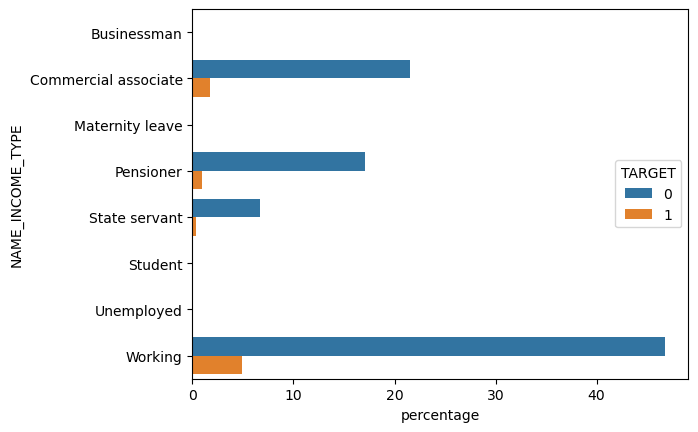

In [25]:
sns.barplot(data=income_dist, y='NAME_INCOME_TYPE', x='percentage', hue='TARGET')

## 2. Preprocessing

2.1. The next step will be to separate our train and test datasets columns between Features (the input to the model) and Targets (what the model has to predict with the given features).

- Assign to `X_train` all the columns from `app_train` that should be used as features for training our models.
- Assign to `y_train` the single column from `app_train` that should be used as our target (i.e. what we want to predict).
- Assign to `X_test` all the columns from `app_test` that should be used as features for training our models.
- Assign to `y_test` the single column from `app_test` that should be used as our target (i.e. what we want to predict).

To do that, you will have to complete the function `data_utils.get_feature_target()` in all the parts with a `TODO` mark.


**Don't change anything in this cell, just make it run correctly**

In [4]:
# Now we execute the function above to get the result
X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)


if X_train.shape == (246008, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (246008,) or y_train.shape == (246008, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_test.shape == (61503, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_test, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_test.shape == (61503,) or y_test.shape == (61503, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


2.2. In order to avoid overfitting while searching for the best model hyperparameters, it's always a good idea to split our training dataset into two new sets called `train` and `validation`.

While the `train` data will be used to fit the model and adjust its internal weights, the `validation` will be exclusively used to test the model performance on unseen data during training, it's like a testing dataset used during experimentation.

Remember we can't use the `test` dataset to validate the model performance because this one lacks of labels :( So the `validation` data will be the only resource you will have to evaluate the final model performance before doing your submission.

To do that, you will have to complete the function `data_utils.get_train_val_sets()` in all the parts with a `TODO` mark.

This function should perform these activities:
- Use the `sklearn.model_selection.train_test_split` function with `X_train`, `y_train` datasets.
- Assign only 20% of the dataset for testing (see `test_size` parameter in `train_test_split`)
- Assign a seed so we get reproducible output across multiple function calls (see `random_state` parameter in `train_test_split`)
- Shuffle the data (see `shuffle` parameter in `train_test_split`)

For reference, see:
- [Scikit-learn train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [Wikipedia: Training, validation, and test data sets](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets)
- [Train Test Validation Split: How To & Best Practices](https://www.v7labs.com/blog/train-validation-test-set)


**Don't change anything in this cell, just make it run correctly**

In [5]:
# Now we execute the function above to get the result
X_train, X_val, y_train, y_val = data_utils.get_train_val_sets(X_train, y_train)


if X_train.shape == (196806, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (196806,) or y_train.shape == (196806, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_val.shape == (49202, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_val, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_val.shape == (49202,) or y_val.shape == (49202, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


2.3. In this section, you will code a function to make all the data pre-processing for the dataset. What you have to deliver is a function that takes `X_train`, `X_val`, and `X_test` dataframes, processes all features, and returns the transformed data as numpy arrays ready to be used for training.

The function should perform these activities, in this order:

1. Correct outliers/anomalous values in numerical columns (`DAYS_EMPLOYED` column)
2. Encode string categorical features (dytpe `object`):
    - If the feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding
3. Impute values for all columns with missing data (use median as imputing value)
4. Feature scaling with Min-Max scaler.

Complete the function `preprocessing.preprocess_data()` following the instructions given above.

In the following cell, we are going to execute the preprocessing function you've just coded. No need to modify this.

**Important Note:** From now on, you must always use `train_data` for training your models and `val_data` only for the final evaluation of the model trained. About `test_data`, it will be used at the end only for submitting your final model predictions and be evaluated on our side with the hidden annotations.


**Don't change anything in this cell, just make it run correctly**

In [28]:
train_data, val_data, test_data = preprocessing.preprocess_data(X_train, X_val, X_test)


if train_data.shape == (196806, 246):
    print("Success: train_data shape is correct!")
else:
    raise ValueError("train_data dataset shape is incorrect, please review your code")

if isinstance(train_data, np.ndarray):
    print("Success: train_data type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if val_data.shape == (49202, 246):
    print("Success: val_data shape is correct!")
else:
    raise ValueError("val_data dataset shape is incorrect, please review your code")

if isinstance(val_data, np.ndarray):
    print("Success: val_data type is correct!")
else:
    raise ValueError("Validation dataset type is incorrect, please review your code")

if test_data.shape == (61503, 246):
    print("Success: test_data shape is correct!")
else:
    raise ValueError("test_data dataset shape is incorrect, please review your code")

if isinstance(test_data, np.ndarray):
    print("Success: test_data type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Input train data shape:  (196806, 121)
Input val data shape:  (49202, 121)
Input test data shape:  (61503, 121) 



Success: train_data shape is correct!
Success: train_data type is correct!
Success: val_data shape is correct!
Success: val_data type is correct!
Success: test_data shape is correct!
Success: test_data type is correct!


## 3. Training Models

As usual, you will start training simple models and will progressively move to more complex models and pipelines.

**Pro tip:** It is of utmost importance to make an accurate estimation of the time required to train a machine learning model. Because of this, we recommend you to use Python [time](https://docs.python.org/3/library/time.html) library or Jupyter magic function `%%time` on the cell you're training your model to get an estimate of the time it took to fit your data.

### Baseline: LogisticRegression

3.1. Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters. If you receive a warning because the algorithm failed to converge, try increasing the number of iterations or decreasing the C parameter.

Assign the trained model to `log_reg` variable.

**Don't change anything in this cell, just make it run correctly**

In [29]:
%%time

# This is an example code on how to:
#   - Create and fit (train) a logistic regression
#   - Assign to `log_reg` variable

log_reg = None
log_reg = LogisticRegression(C=0.0001)
log_reg.fit(train_data, y_train)

CPU times: user 8.78 s, sys: 2.63 s, total: 11.4 s
Wall time: 1.72 s


LogisticRegression(C=0.0001)

**Don't change anything in this cell, just make it run correctly**

In [30]:
if isinstance(log_reg, LogisticRegression):
    print("Success: Logistic regression model type is correct!")
else:
    raise ValueError(
        "Logistic regression model type is incorrect, please review your code"
    )

check_is_fitted(log_reg)

Success: Logistic regression model type is correct!


3.2. Use the trained model to predict probabilities for `train_data` and `val_data`.

**Important note:** When using the function `predict_proba()` for getting model probabilities you will get, for each sample, a tuple indicating the probability for class 0 and for class 1 respectively. For computing the AUC ROC score we only need the probability that the debt is not repaid (equivalent to class 1). As an example, the result from running `predict_proba()` on validation dataset will have a shape of `(49202, 2)` but, we only need the second column from that matrix, which corresponds to the class 1.


**Don't change anything in this cell, just make it run correctly**

In [31]:
# Example code to show you how to use the Logistic Regression model
# to predict probabilities for each class and then, use the probabilities for the
# class 1 only.

# Train data predictions (class 1)
log_reg_train = log_reg.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
log_reg_val = log_reg.predict_proba(val_data)[:, 1]

3.3. Get AUC ROC score on train and validation datasets. See [scikit-learn AUC ROC function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) for a working implementation.

Assign the AUC ROC score to `lr_roc_auc` variable.


**Don't change anything in this cell, just make it run correctly**

In [32]:
# Example code to show you how to get the ROC AUC Score on train and val datasets

# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=log_reg_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=log_reg_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.6787
Validation ROC AUC Score: 0.6824


At this point, the model should produce a result of around 0.67.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

**Don't change anything in this cell, just make it run correctly**

In [33]:
if isinstance(roc_auc_val, float):
    print("Success: AUC ROC score type is correct!")
else:
    raise ValueError("AUC ROC score type is incorrect, please review your code")

if roc_auc_val >= 0.6:
    print("Success: AUC ROC score is correct!")
else:
    raise ValueError("AUC ROC score is incorrect, please review your code")

Success: AUC ROC score type is correct!
Success: AUC ROC score is correct!


### Training a Random Forest Classifier

You're gonna start working in more complex models: ensambles, particularly, you're going to use the Random Forest Classifier from Scikit Learn.

3.4. Train a RandomForestClassifier, print the time taken by the fit function. Just use default hyperparameters, except for `n_jobs`, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [34]:
%%time

# TODO Write your code here for training a Random Forest model.
#   - Please use sklearn.ensemble.RandomForestClassifier() class.
#   - Assign the model to the variable `rf`.
#   - Remember to fit the model only on `train_data`.

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(train_data, y_train)

CPU times: user 3min 32s, sys: 905 ms, total: 3min 33s
Wall time: 29.4 s


RandomForestClassifier(n_jobs=-1, random_state=42)

**Don't change anything in this cell, just make it run correctly**

In [35]:
if isinstance(rf, RandomForestClassifier):
    print("Success: RandomForestClassifier model type is correct!")
else:
    raise ValueError(
        "RandomForestClassifier model type is incorrect, please review your code"
    )

check_is_fitted(rf)

Success: RandomForestClassifier model type is correct!


3.5. Use the classifier to predict probabilities for `train_data` and `val_data`.

In [36]:
# TODO Use the Random Forest model to predict probabilities for each class and then,
# use the probabilities for the class 1 only.

# Train data predictions (class 1)
rf_pred_train = rf.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
rf_pred_val = rf.predict_proba(val_data)[:, 1]

In [37]:
# TODO Get the ROC AUC Score on train_data and val_data datasets.
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=rf_pred_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.7091


At this point, the model should produce a result around 0.7.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

### Randomized Search with Cross Validation

So far, we've only created models using the default hyperparameters of each algorithm. This is usually something that we would only do for baseline models, hyperparameter tuning is a very important part of the modeling process and is often the difference between having an acceptable model or not.

But, there are usually lots of hyperparameters to tune and a finite amount of time to do it, you have to consider the time and resources it takes to find an optimal combination of them. In the previous section you trained a random forest classifier and saw how much it took to train it once in your PC. If you want to do hyperparameter optimization you now have to consider that you will have to train the algorithm N number of times, with N being the cartesian product of all parameters.

Furthermore, you can't validate the performance of your trained models on the test set, as this data should only be used to validate the final model. So we have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because we will have to train each combinations of hyperparameters M number of times, X being the number of folds in which we divided our dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here you're going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid.

Remember: take in consideration how much time it took to train a single classifier, and define the number of cross validations folds and iterations of the search accordingly.
A recommendation: run the training process, go make yourself a cup of coffee, sit somewhere comfortably and forget about it for a while.


3.7. Use `sklearn.model_selection.RandomizedSearchCV()` to find the best combination of hyperparameters for a Random Forest model.

The validation metric used to evaluate the models should be "roc_auc" (i.e. `scoring="roc_auc"`).

In [38]:
%%time

# TODO Write your code here for training a Random Forest model using Random Search
# of hyper-parameters.
#   - Please use sklearn.model_selection.RandomizedSearchCV() and
#     sklearn.ensemble.RandomForestClassifier() classes.
#   - Assign the RandomizedSearchCV model to the variable `rf_random`.
#   - Remember to fit the model only on `train_data`.

param_dist = {
    "n_estimators":[12,20],
    "max_depth": [10,15],
    "min_samples_split": [5,10],
    "min_samples_leaf": [2,4]
}

rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(),
                               param_distributions=param_dist,
                               n_jobs=-1)

rf_random.fit(train_data, y_train)

print("Results from Random Search \n" )
print("The best estimator across ALL searched params:")
print(rf_random.best_estimator_)
print("The best parameters across ALL searched params:")
print(rf_random.best_params_)

Results from Random Search 

The best estimator across ALL searched params:
RandomForestClassifier(max_depth=15, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=20)
The best parameters across ALL searched params:
{'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 15}
CPU times: user 20 s, sys: 957 ms, total: 20.9 s
Wall time: 2min 43s


In [39]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=15, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=20)

3.8. Use the classifier to predict probabilities on the train and test data.


In [40]:
# TODO Use the RandomizedSearchCV model to predict probabilities for each class and
# then, use the probabilities for the class 1 only.

# Train data predictions (class 1)
rf_tuned_pred_train = rf_random.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
rf_tuned_pred_val = rf_random.predict_proba(val_data)[:, 1]

3.9. Get AUC ROC score on train and validation datasets.

In [41]:
# TODO Get the ROC AUC Score on train_data and val_data datasets.
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_tuned_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=rf_tuned_pred_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.8949
Validation ROC AUC Score: 0.7106


At this point, the model should produce a result around 0.7 or higher.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

## 4. Predict unlabeled data

Now it's time to finally use the `test_data` samples. Because we don't have the labels we can't see how the model performs on this dataset (╯°□°)╯︵ ┻━┻

But... don't worry, we will internally evaluate your model and give feedback on the results!

In the cells below:
- Take your best model
- Take `test_data` (i.e. the dataset after doing the preprocessing and feature engineering part)
- Run the data through your model and save the predictions on the `TARGET` column in the `app_test` DataFrame (yeah that we've loaded at the very beginning of this notebook).
    - `TARGET` column values must be the probabilities for class 1. So remember to use the `predict_proba()` function from your model as we did in the previous sections.
- Save the modified version of the DataFrame with the same name it has before (`dataset/application_test_aai.csv`) and don't forget to submit it alongside the rest of this sprint project code
- And finally, don't get confused, you shouldn't submit `dataset/application_train_aai.csv`. So please don't upload your solution with this heavy dataset inside.

Let's say your best model is called `best_credit_model_ever`, then your code should be exactly this:

```python
    test_preds = best_credit_model_ever.predict_proba(test_data)[:, 1]
    app_test["TARGET"] = test_preds
    app_test.to_csv(config.DATASET_TEST, index=False)
```


In [42]:
X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)

In [43]:
train_data, test_data, preprocessor = preprocessing.preprocess_data_2(X_train, X_test)

Input train data shape:  (246008, 121)
Input test data shape:  (61503, 121) 



In [44]:
%%time

# TODO Use your best model and call the predict_proba() on test_data then,
# use the probabilities for the class 1 only.
# Then, put the predictions in app_test["TARGET"] and save the DataFrame as a csv
# with the same name it originally has ("application_test_aai.csv").

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=529)

X = train_data
y = np.array(y_train)

fold = 0
aucs = []
for train_idx, val_idx in kfold.split(X, y):
    X_tr = X[train_idx]
    y_tr = y[train_idx]
    
    X_valid = X[val_idx]
    y_valid = y[val_idx]

    # Fit Model on Train
    clf = lgb.LGBMClassifier(n_estimators=100,
                             objective='binary',
                             num_leaves=31,
                             learning_rate=0.05,
                             is_unbalance=True)
    clf.fit(X_tr, y_tr)

    pred_prob = clf.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, pred_prob)

    print(f"======= Fold {fold} ========")
    print(f"AUC is {auc_score:0.4f}" )
    print(clf.get_params())
    # print(clf.best_iteration_)
    
    fold += 1
    aucs.append(auc_score)

oof_auc = np.mean(aucs)
print(f"======= Out of fold ========")
print(f'Out of fold AUC score is {oof_auc:0.4f}')

[LightGBM] [Info] Number of positive: 15801, number of negative: 181005
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11480
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080287 -> initscore=-2.438451
[LightGBM] [Info] Start training from score -2.438451
======= Fold 0 ========
AUC is 0.7548
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'is_unbalance': True}
[LightGBM] [Info] 

In [45]:
lgb_clf_alt = lgb.LGBMClassifier(n_estimators=100, objective='binary', num_leaves=31, learning_rate=0.05, is_unbalance=True)
lgb_clf_alt.fit(train_data, y_train)

[LightGBM] [Info] Number of positive: 19751, number of negative: 226257
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11492
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 117
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080286 -> initscore=-2.438467
[LightGBM] [Info] Start training from score -2.438467


LGBMClassifier(is_unbalance=True, learning_rate=0.05, objective='binary')

In [46]:
lgb_pred_test = lgb_clf_alt.predict_proba(test_data)[:, 1]

In [47]:
app_test["TARGET"] = lgb_pred_test
app_test.to_csv(config.DATASET_TEST, index=False)

## 5. Optional exercises

### Optional: Training a LightGBM model

5.1. Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Lots of competitions have been won using models from libraries like XGBoost or LightGBM. You can try using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a new model an see how it performs compared to the other classifiers you trained.

In [48]:
X_train, X_val, y_train, y_val = data_utils.get_train_val_sets(X_train, y_train)

In [49]:
train_data, val_data, test_data, preprocessor = preprocessing.preprocess_data_1(X_train, X_val, X_test)

Input train data shape:  (196806, 121)
Input val data shape:  (49202, 121)
Input test data shape:  (61503, 121) 



In [50]:
type(preprocessor)

sklearn.compose._column_transformer.ColumnTransformer

In [51]:
### Complete in this cell: Make you own experimentation process

lgb_clf_alt = lgb.LGBMClassifier(n_estimators=100, objective='binary', num_leaves=31, learning_rate=0.05, is_unbalance=True)
lgb_clf_alt.fit(train_data, y_train)

[LightGBM] [Info] Number of positive: 15850, number of negative: 180956
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11490
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080536 -> initscore=-2.435084
[LightGBM] [Info] Start training from score -2.435084


LGBMClassifier(is_unbalance=True, learning_rate=0.05, objective='binary')

In [52]:
lgb_pred_train = lgb_clf_alt.predict_proba(train_data)[:, 1]
lgb_pred_val = lgb_clf_alt.predict_proba(val_data)[:, 1]

In [53]:
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=lgb_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=lgb_pred_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.7824
Validation ROC AUC Score: 0.7540


In [54]:
lgb_class_pred_val = np.where(lgb_pred_val > 0.67, 1, 0)

In [55]:
print(classification_report(y_val, lgb_class_pred_val))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     45301
           1       0.24      0.39      0.30      3901

    accuracy                           0.86     49202
   macro avg       0.59      0.64      0.61     49202
weighted avg       0.89      0.86      0.87     49202



### Optional: Using Scikit Learn Pipelines

5.2. So far you've created special functions or blocks or code to chain operations on data and then train the models. But, reproducibility is important, and you don't want to have to remember the correct steps to follow each time you have new data to train your models. There are a lots of tools out there that can help you with that, here you can use a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to process your data.

In [56]:
### Complete in this cell: use a sklearn Pipeline to automate the cleaning, standardizing and training

### Optional: Build your own model and features

5.3. If you want you can take the original labeled data given and make your own feature selection, data preprocessing, and model tunning. Be creative, the only limit is time and hardware resources. Only be careful and don't modify the previous functions made in the mandatory assignments or, you will break the project tests.

You can even use this newer model to make predictions in the test dataset with hidden labels and submit that.


In [57]:
### Complete in this cell: Make you own experimentation process

**In this section, I used a different encoder: TargetEncoder. It can be used with scikit-learn version 1.3.1, which is not in the requirements listed in requirements.txt. Therefore there is commented code here. At the end you can see the prediction scores.**

``` python
from typing import Tuple

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


def preprocess_data_target(
    train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, y_train: pd.Series
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    print("Input train data shape: ", train_df.shape)
    print("Input val data shape: ", val_df.shape)
    print("Input test data shape: ", test_df.shape, "\n")

    working_train_df = train_df.copy()
    working_val_df = val_df.copy()
    working_test_df = test_df.copy()

    working_train_df["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)
    working_val_df["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)
    working_test_df["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)

    nan_categorical_features = ['NAME_TYPE_SUITE',
                                'OCCUPATION_TYPE',
                                'FONDKAPREMONT_MODE',
                                'HOUSETYPE_MODE',
                                'WALLSMATERIAL_MODE',
                                'EMERGENCYSTATE_MODE']

    full_categorical_features = ['NAME_CONTRACT_TYPE',
                                 'CODE_GENDER',
                                 'FLAG_OWN_CAR',
                                 'FLAG_OWN_REALTY',
                                 'NAME_INCOME_TYPE',
                                 'NAME_EDUCATION_TYPE',
                                 'NAME_FAMILY_STATUS',
                                 'NAME_HOUSING_TYPE',
                                 'WEEKDAY_APPR_PROCESS_START',
                                 'ORGANIZATION_TYPE']
    
    nan_categorical_transformer = Pipeline(
        steps=[
            ("encoder", TargetEncoder(target_type='binary', smooth=100000))
        ]
    )

    full_categorical_transformer = Pipeline(
        steps=[
            ("encoder", TargetEncoder(target_type='binary', smooth='auto'))
        ]
    )

    numeric_features = list(set(working_train_df.columns)- set(nan_categorical_features + full_categorical_features))

    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", MinMaxScaler())
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("nan_cat", nan_categorical_transformer, nan_categorical_features),
            ("full_cat", full_categorical_transformer, full_categorical_features)
        ]
    )

    train = preprocessor.fit_transform(working_train_df, y_train)
    val = preprocessor.transform(working_val_df)
    test = preprocessor.transform(working_test_df)

    return train, val, test, preprocessor
```

In [71]:
# from typing import Tuple

# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, TargetEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline


# def preprocess_data_target(
#     train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, y_train: pd.Series
# ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

#     print("Input train data shape: ", train_df.shape)
#     print("Input val data shape: ", val_df.shape)
#     print("Input test data shape: ", test_df.shape, "\n")

#     working_train_df = train_df.copy()
#     working_val_df = val_df.copy()
#     working_test_df = test_df.copy()

#     working_train_df["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)
#     working_val_df["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)
#     working_test_df["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)

#     nan_categorical_features = ['NAME_TYPE_SUITE',
#                                 'OCCUPATION_TYPE',
#                                 'FONDKAPREMONT_MODE',
#                                 'HOUSETYPE_MODE',
#                                 'WALLSMATERIAL_MODE',
#                                 'EMERGENCYSTATE_MODE']

#     full_categorical_features = ['NAME_CONTRACT_TYPE',
#                                  'CODE_GENDER',
#                                  'FLAG_OWN_CAR',
#                                  'FLAG_OWN_REALTY',
#                                  'NAME_INCOME_TYPE',
#                                  'NAME_EDUCATION_TYPE',
#                                  'NAME_FAMILY_STATUS',
#                                  'NAME_HOUSING_TYPE',
#                                  'WEEKDAY_APPR_PROCESS_START',
#                                  'ORGANIZATION_TYPE']
    
#     nan_categorical_transformer = Pipeline(
#         steps=[
#             ("encoder", TargetEncoder(target_type='binary', smooth=100000))
#         ]
#     )

#     full_categorical_transformer = Pipeline(
#         steps=[
#             ("encoder", TargetEncoder(target_type='binary', smooth='auto'))
#         ]
#     )

#     numeric_features = list(set(working_train_df.columns)- set(nan_categorical_features + full_categorical_features))

#     numeric_transformer = Pipeline(
#         steps=[
#             ("imputer", SimpleImputer(strategy="median")),
#             ("scaler", MinMaxScaler())
#         ]
#     )

#     preprocessor = ColumnTransformer(
#         transformers=[
#             ("num", numeric_transformer, numeric_features),
#             ("nan_cat", nan_categorical_transformer, nan_categorical_features),
#             ("full_cat", full_categorical_transformer, full_categorical_features)
#         ]
#     )

#     train = preprocessor.fit_transform(working_train_df, y_train)
#     val = preprocessor.transform(working_val_df)
#     test = preprocessor.transform(working_test_df)

#     return train, val, test, preprocessor

In [72]:
# train_data, val_data, test_data, preprocessor = preprocess_data_target(X_train, X_val, X_test, np.array(y_train))

Input train data shape:  (196806, 121)
Input val data shape:  (49202, 121)
Input test data shape:  (61503, 121) 



In [73]:
# lgb_clf_target = lgb.LGBMClassifier(n_estimators=100, objective='binary', num_leaves=31, learning_rate=0.05, is_unbalance=True)
# lgb_clf_target.fit(train_data, y_train)

[LightGBM] [Info] Number of positive: 15850, number of negative: 180956
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11962
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080536 -> initscore=-2.435084
[LightGBM] [Info] Start training from score -2.435084


LGBMClassifier(is_unbalance=True, learning_rate=0.05, objective='binary')

In [74]:
# lgb_pred_train = lgb_clf_target.predict_proba(train_data)[:, 1]
# lgb_pred_val = lgb_clf_target.predict_proba(val_data)[:, 1]

In [75]:
# # Train ROC AUC Score
# roc_auc_train = roc_auc_score(y_true=y_train, y_score=lgb_pred_train)
# print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# # Validation ROC AUC Score
# roc_auc_val = roc_auc_score(y_true=y_val, y_score=lgb_pred_val)
# print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.7843
Validation ROC AUC Score: 0.7567


In [77]:
# lgb_class_pred_val = np.where(lgb_pred_val > 0.69, 1, 0)

In [81]:
# print(classification_report(y_val, lgb_class_pred_val))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93     45301
           1       0.26      0.35      0.30      3901

    accuracy                           0.87     49202
   macro avg       0.60      0.63      0.61     49202
weighted avg       0.89      0.87      0.88     49202



Classification report for the lightgbm model with target encoding.

|precision|recall|f1-score|support| 
|--------:|-----:|-------:|------:|
| 0.94    | 0.91 | 0.93   | 45301 |
| 0.26    | 0.35 | 0.30   | 3901  |